# Fitting Red Giant Oscillations Part 1: *Traditional Optimization*

***Authors: Marc Hon***

The oscillations of Sun-like stars and red giants have a characteristic signature in the frequency domain. Fitting this signature allows us to determine fundamental properties of such stars.
Here, we will explore how such fits are performed in practice.

Let's import the necessary libraries for this notebook.

In [1]:
import warnings, math
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import time as timer
import scienceplots

from pathlib import Path
from astropy.table import Table
from astropy.units import UnitsWarning

warnings.filterwarnings('ignore', category=UnitsWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter1' / 'data'

plt.style.use('science')
fs = 18

In [2]:
rg_data = Table.read(data_folder_path / 'hlsp_kepseismic_kepler_phot_kplr006144777-80d_kepler_v1_cor-filt-inp.fits').to_pandas()
rg_data

,TIME,FLUX
0,54953.538687,-0.000094
1,54953.559121,291.722156
2,54953.579554,390.444995
3,54953.599988,457.692529
4,54953.620422,375.413547
...,...,...
71958,56423.912748,-410.470799
71959,56423.933182,-473.127270
71960,56423.953616,-33.787705
71961,56423.974050,-149.718131


We will be computing the Lomb-Scargle periodogram of a time series observed by the <i>Kepler</i> mission. This time series is based on observations of the red giant KIC 6144777.

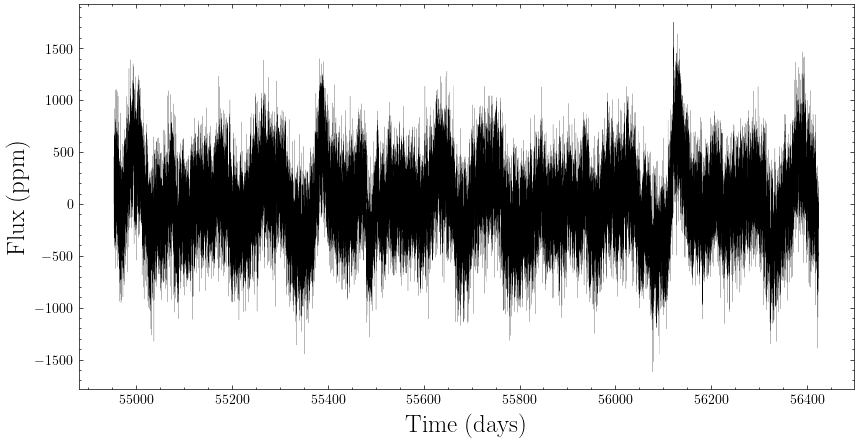

In [3]:
fig = plt.figure(figsize=(10, 5))
plt.plot(rg_data.TIME, rg_data.FLUX, lw=0.1, c='k');
plt.ylabel(r'Flux (ppm)', fontsize=fs);
plt.xlabel(r'Time (days)', fontsize=fs);

The computation of the Lomb-Scargle periodogram will be performed using the handy package `periodogram`, which can be obtained by `pip install periodogram`. The Power Spectral Density module (`psd`) of the package computes returns the frequency (`freq`) and power density (`power`) of the Lomb-Scargle periodogram.

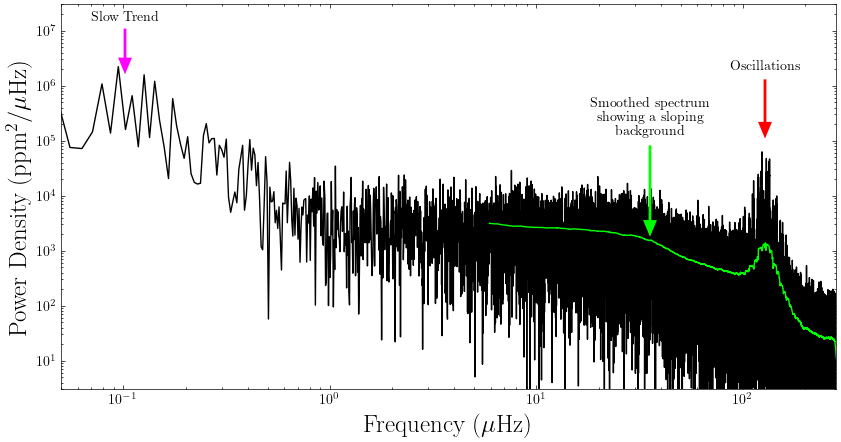

In [4]:
from periodogram import psd
from astropy.convolution import convolve, Box1DKernel


freq, power = psd(rg_data.TIME.values*u.d.to(u.Ms), rg_data.FLUX)

# heavily smooth spectrum using a boxcar kernel of 10uHz length
smooth_power = convolve(power, Box1DKernel(math.ceil((10. / np.diff(freq)[0])))) 


fig = plt.figure(figsize=(10, 5))
plt.loglog(freq, power, c='k')
plt.loglog(freq[750:], smooth_power[750:], c='lime')

plt.xlim(0.05, 283)
plt.ylim(3,3e7)
plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs)
plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)

plt.annotate('Oscillations', xy=(0.765, 0.6), xytext=(.765, 0.75), xycoords='figure fraction',
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10, edgecolor='none'),
             ha='center', va='center')

plt.annotate('Slow Trend', xy=(0.125, 0.73), xytext=(.125, 0.85), xycoords='figure fraction',
             arrowprops=dict(facecolor='magenta', shrink=0.05, width=2, headwidth=10, edgecolor='none'),
             ha='center', va='center')

plt.annotate('Smoothed spectrum\nshowing a sloping\nbackground', xy=(0.65, 0.4), xytext=(.65, 0.65), xycoords='figure fraction',
             arrowprops=dict(facecolor='lime', shrink=0.05, width=2, headwidth=10, edgecolor='none'),
             ha='center', va='center')

plt.show()

> **Important**  
> The variations seen in red giants are typically at timescales of days to months. This makes $\mu$Hz a natural choice for viewing the frequency range corresponding to such timescales. Importantly, the time array to `psd` needs to be the inverse of $\mu$Hz -- which is megasecond (Ms).


## Components of the Power Density Profile

The power density profile of the star has several components: a <span style="color: magenta;">slow trend</span> that arises from stellar activity such as rotation, a <span style="color: lime;">sloping background</span> from surface granulation, and the <span style="color: red;">red giant oscillations</span>.

A model of the power density ($P$) as a function of frequency ($\nu$) can be described by the following:

$$
\begin{aligned}
P(\nu) = P_n + \sum\limits_{i} \frac{A_i}{1 + (\nu/b_i)^c} + P_g \exp \frac{(\nu-\nu_{\mathrm{max}})^2}{2\sigma^2}
\end{aligned}
$$

This is the general form of the power density as presented by [Kallinger et al. (2014)](https://www.aanda.org/articles/aa/full_html/2014/10/aa24313-14/aa24313-14.html). Let's unpack this equation.

- $P_n$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; This is the white noise level of the data. In the power spectrum, this presents as flat background, or an additive constant across all frequencies.
- $\sum\limits_{i} \frac{A_i}{1 + (\nu/b_i)^c}$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A sum of Lorentzian functions describing the variation of the background (e.g., 1/$\nu$ granulation noise, low-frequency activity) with frequency. Each term is commonly described as a ***Harvey model*** in literature.
- $P_g \exp \frac{(\nu-\nu_{\mathrm{max}})^2}{2\sigma^2}$: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The oscillation power excess, parameterized by a Gaussian profile of height $P_g$, center $\nu_{\mathrm{max}}$, and width $\sigma$.


> **Note**  
> Lorentzian functions take the form $ \dfrac{b}{(x-a)^2+b^2} $, where $a$ and $b$ are constants.



The fit to the power density thus requires a model describing the superposition of the signal from oscillations atop noise contributions from other background components. To describe granulation noise, it is common that two Harvey models are adopted.

Here, we define code to build the power spectrum model with two Harvey models that have $c=4$.

In [5]:
def _sLor(nu, A, b, c):
    return A / (1 + (nu / b) ** c)

def _sinc(x):
    return np.sinc(x/np.pi)

def bgModel(theta, nu, no_osc=False, nuNyq = 283.):
  """
  Background model value at a given frequency 'nu'
  """
  Pn, A2, b2, A3, b3, Pg, numax, sigmaEnv = theta
  sc = _sinc(np.pi * nu / (2 * nuNyq)) ** 2
  bg = Pn
  bg = bg + sc * _sLor(nu, A2, b2, 4)
  bg = bg + sc * _sLor(nu, A3, b3, 4)
  if not no_osc:
      bg = bg + sc * Pg * np.exp(-((nu - numax) ** 2) / (2 * sigmaEnv ** 2))
  return bg

## First Guesstimate

param_dict = {'logPn': 10**1.0,
             'A2': 10**3.26,
             'b2': 50.,
             'A3': 10**2.50,
             'b3': 150.,
             'P_g': 900,
             'numax': 130.,
             'sigmaEnv': 0.28*130**0.88}

theta = [k for k in param_dict.values()]

We will be adopting an initial set of parameters in `theta` ,as shown in the following:

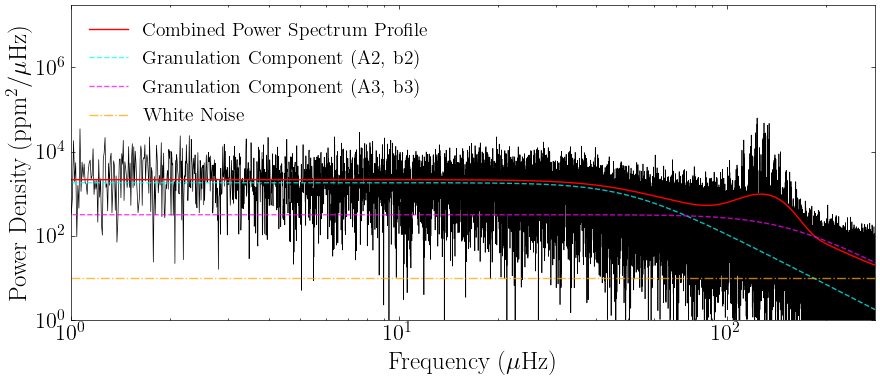

In [164]:
plt.figure(figsize=(9, 4))

plt.loglog(freq, power, c='k', lw=0.5)
plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs)
plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
plt.xlim(1, 283)
plt.ylim(1, 3e7)
plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)

plt.plot(freq, bgModel(theta, freq), c='r', label='Combined Power Spectrum Profile')
plt.plot(freq, _sLor(freq, param_dict['A2'],
                             param_dict['b2'], 
                             4), c='cyan', ls='--', label='Granulation Component (A2, b2)', alpha=0.75)
plt.plot(freq, _sLor(freq, param_dict['A3'],
                         param_dict['b3'], 
                         4), c='magenta', ls='--', label='Granulation Component (A3, b3)', alpha=0.75)
plt.axhline(y=param_dict['logPn'], c='orange', label='White Noise', ls='-.', alpha=0.75)

plt.legend(loc='best', prop={'size': fs-4})

plt.tight_layout(w_pad=1.5)
plt.show()


## Maximum Likelihood Fitting

The fit above was performed manually (by eye) and looks reasonable at first glance. With a manual approach, we cannot easily know if this was a good fit, nor would it be feasible to repeat the analysis over a larger sample of targets.

We thus turn to a statistical approach, namely the maximum likelihood estimate of fits to the power spectrum. The probability $P_i$ in frequency bin $i$ in a white noise spectrum follows a $\chi^2$ two degrees of freedom distribution:

$$
\begin{align}
    P_i &= \frac{1}{\text{Model}}\exp\bigg(\frac{-\text{Observed}}{\text{Model}}\bigg).
\end{align}
$$

The likelihood of observed data over $i$ frequency bins is the joint probability density over those bins, $L = \prod\limits_{i} P_i$. A more numerically stable approach would be to calculate the logarithm of the likelihood:

$$
\begin{align}
    -\ln L &= \sum\limits_{i} \bigg[ \ln(\text{Model}_i) + \frac{\text{Observed}_i}{\text{Model}_i} \bigg].
\end{align}
$$

We are now going to define a likelihood function as the following:

In [267]:
class lnlike_mle(object):
    def __init__(self, _freq, _power, _model, p0):
        self.freq = _freq
        self.power = _power
        self.model = _model # model power spectrum
        self.p0 = p0  # initial parameters to optimize

    def __call__(self, params, update_vars):
        
        for var, val in zip(update_vars, params):
            self.p0.update({var: val})
        
        # Construct model for given set of parameters
        mod = self.model(list(self.p0.values()), self.freq)

        like = np.sum(np.log(mod) + self.power / mod)
        if not np.isfinite(like):
            return 1.0e30
        return like

### Putting all power spectrum properties together 

For convenience, let us collate the properties and functions of the power spectrum in a Class instance called `Spectrum`:

In [7]:
class Spectrum(object):

    def __init__(self, _freq, _power, _numax, nuNyq=283.):
        self.freq = _freq
        self.power = _power
        self.numax0 = _numax
        self.nuNyq = nuNyq
        self._maxPDS = 1.0*np.nanmax(self.power)

    def par_rels(self):
      """
      Empirical exponential relations between background parameters and numax.
      parameter = k*numax^s. First column is 'k', second is 's'
      """
      return {"Pn"       : [1.000000e00,  0.000000], # Inferred from data, left alone
#               "A1"       : [1.000000e00,  0.000000], # Inferred from data, left alone
#               "b1"       : [0.5787,  0], # For filter of length 40 days
#               "c1"       : [4, 0.0],
              "A2"       : [3382, -0.609], # K2014
              "b2"       : [0.317,  0.970], # K2014
              "A3"       : [3382, -0.609], # K2014
              "b3"       : [0.948,  0.992], # K2014
              "Pg"       : [2.03e7, -2.38], # M2012
              "numax"    : [1.000000e-00,  1.000000],
              "sigmaEnv" : [0.28,  0.88]} # M2012

    def guess_from_numax(self, param, numax):
        return self.par_rels()[param][0] * (numax ** self.par_rels()[param][1])

    def initial_guess(self):
        return np.array([self.guess_from_numax(ix, self.numax0) for ix in list(self.par_rels().keys())])

spec = Spectrum(_freq = freq, _power = power, _numax = 100)
theta = spec.initial_guess()
theta

array([  1.        , 204.72628384,  27.6095458 , 204.72628384,
        91.37099144, 352.77356824, 100.        ,  16.11231825])

We initialize the class with the power spectrum data and a rough guess of $\nu_{\mathrm{max}}=100\mu$Hz. 

Again, we have an initial guess vector `theta`, but these now based on relations in the form of $k\cdot\nu_{\mathrm{max}}^s$. The coefficients for these exponential relations were determined empirically from fitting an ensemble of <i>Kepler</i> red giants from the works by [Mosser et al. (2012)](https://www.aanda.org/articles/aa/abs/2012/01/aa17352-11/aa17352-11.html) and [Kallinger et al. (2014)](https://www.aanda.org/articles/aa/full_html/2014/10/aa24313-14/aa24313-14.html). From the rough guess of $\nu_{\mathrm{max}}$, initial parameters for the coefficients describing the power spectrum are estimated. It is useful to have a choice of initial parameters that are not too distant from a true maximum likelihood estimate.

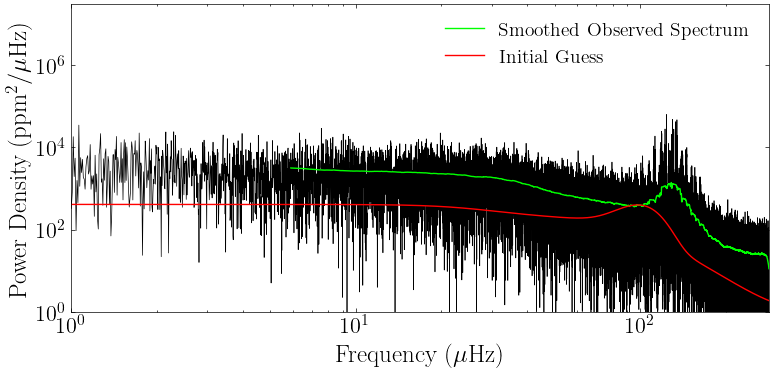

In [269]:
plt.figure(figsize=(9, 4))

plt.loglog(spec.freq, spec.power, c='k', lw=0.5)
plt.loglog(freq[750:], smooth_power[750:], c='lime', label='Smoothed Observed Spectrum')
plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs)
plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
plt.xlim(1, 283)
plt.ylim(1, 3e7)
plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)

plt.plot(spec.freq, bgModel(spec.initial_guess(), spec.freq), c='r', label='Initial Guess')
plt.legend(prop={'size': fs-4})
plt.show()

The initial guess isn't great! Let's optimize for the maximum likelihood solution.

## Optimizing the Likelihood

We can use `scipy.optimize.minimize` to run an optimization over the likelihood function in Eqn. {eq}`loglike_psd`. Because the function provides the ***negative log-likelihood***, the optimization objective is to ***minimize*** the function's output.

In [13]:
import scipy.optimize as op

def optimize(parameters, vars=None):
    """Optimises the `parameters` with Scipy

    Parameters
    ----------
    vars : list, optional
        List of vars to optimize, by default None

    Returns
    -------
    dict
        Results of the optimization
    """
    if vars is None:
        vars = list(parameters.keys())

    x0 = [parameters[var] for var in vars]   
    soln = op.minimize(Lnlike_MLE, x0, args=(vars))
    for var, val in zip(vars, soln.x):
        parameters.update({var: val})
    return parameters

p0_dict = dict(zip(spec.par_rels().keys(), spec.initial_guess())) # Initial guess encoded in a dictionary

# Run optimisation
Lnlike_MLE = lnlike_mle(spec.freq, spec.power, _model = bgModel, p0 = p0_dict)

result_p0 = optimize(p0_dict, vars=['A3', 'b3', 'Pn'])   # optimize A2, b2, keep others fixed
result_p0 = optimize(result_p0, vars=['A2', 'b2']) # optimize A3, b3, keep others fixed
result_p0 = optimize(result_p0, vars=['Pg', 'numax', 'sigmaEnv']) # optimize Pg, numax, sigmaEnv, keep others fixed
result_p0 = optimize(result_p0)

> **Optimization Tip**  
> Notice that the optimization is done over subsets of the free parameters at a given time. This is known as ***block coordinate descent*** and is useful for optimizing over a high-dimensional vector of free parameters as it can help with convergence and stability.

In [271]:
pd.DataFrame({
    'Parameter': spec.par_rels().keys(),
    'Initial Guess': [f"{x:.4f}" for x in spec.initial_guess()],
    'Optimized Result': [f"{x:.4f}" for x in result_p0.values()]
})

,Parameter,Initial Guess,Optimized Result
0,Pn,1.0000,27.4144
1,A2,204.7263,71517.5023
2,b2,27.6095,0.4562
3,A3,204.7263,2239.3082
4,b3,91.3710,50.1397
5,Pg,352.7736,974.7156
6,numax,100.0000,126.7485
7,sigmaEnv,16.1123,18.7959


The optimization seems to have converged to a result across these parameters. Let's observe what this fit looks like.

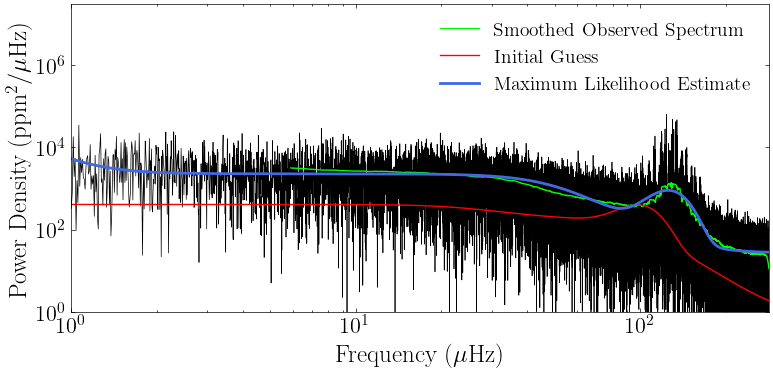

In [272]:
plt.figure(figsize=(9, 4))

plt.loglog(spec.freq, spec.power, c='k', lw=0.5)
plt.loglog(freq[750:], smooth_power[750:], c='lime', label='Smoothed Observed Spectrum')

plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs)
plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
plt.xlim(1, 283)
plt.ylim(1, 3e7)
plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)

plt.plot(spec.freq, bgModel(spec.initial_guess(), spec.freq), c='r', label='Initial Guess')
plt.plot(spec.freq, bgModel(result_p0.values(), spec.freq), c='royalblue', label='Maximum Likelihood Estimate',lw=2)
plt.legend(prop={'size': fs-4})
plt.show()

The maximum likelihood estimate fits the data much better! 

## Obtaining Uncertainties

The optimization from the maximum likelihood technique provides a ***point estimate***. It is often desirable to determine uncertainties from this fit, which will inform us about how secure of our identification of this fit as the best solution. Given prior knowledge about the parameter space, we want to sample a range of likelihood values near our solution, which effectively gives us a posterior distribution as per Bayes' rule:

$$
\begin{align}
    \overbrace{p(y|\theta)}^{\text{Posterior}} \propto \underbrace{\mathcal{L}}_{\text{Likelihood}} \times \underbrace{p(\theta)}_{\text{Prior}}.
\end{align}
$$

A crucial ingredient that we need here is the prior distribution, which encodes any constraints that we have regarding the parameters.

### The prior distribution

In [8]:
def logPrio(self, theta):
    Pn, A2, b2, A3, b3, Pg, numax, sigmaEnv = theta

    def check_condition(condition, msg):
        if not condition:
            # print(f"Failed prior: {msg}")
            return -np.inf
        return 0.0

    # List of priors
    conditions = [
        (0 < Pn < self._maxPDS, "Noise cannot be greater than the max PDS value"),
        (A2 > A3, "Relative ordering of granulation amplitudes"),
        (A3 > 0, "Granulation amplitude must be physical"),
        (b2 < b3, "Relative ordering of granulation timescales"),
        (b3 < 1.1 * self.nuNyq, "Second granulation timescale cannot be too fast"),
        (b2 < 1.3 * self.numax0, "First granulation timescale cannot be too fast"),
        (b3 > 0.2 * self.numax0, "Granulation timescale cannot be too slow"),
        (self.numax0 * 0.7 < numax < self.numax0 * 1.3, "Sampled numax cannot stray too far from initial estimate"),
        (0.1 * self.guess_from_numax("Pg", self.numax0) < Pg < 60 * self.guess_from_numax("Pg", self.numax0),
         "Restrict power excess height to physical values"),
        (0.3 * self.guess_from_numax("sigmaEnv", self.numax0) < sigmaEnv < 3.0 * self.guess_from_numax("sigmaEnv", self.numax0), 
         "Restrict power excess width to physical values")
    ]

    for condition, msg in conditions:
        if check_condition(condition, msg) == -np.inf:
            return -np.inf

    return 0.0

Spectrum.prior = logPrio   # insert this prior function into the Spectrum class
spec_mcmc = Spectrum(_freq = freq, _power = power, _numax = 100)

The above function lists several priors that are known to work well in practice, which mostly restrict the parameters to a range that is known to be physical. In particular, the function informs the sampler about the feasibility of points by returning a ***log probability*** that is infinitely improbable for a sampled value that is out of range.

### The likelihood

We adopt a likelihood function that is similar to the maximum likelihood estimate approach, as shown in the following.

> **A Detail on the Log-Likelihood**  
> Notice the multiplication with $-1$ in the log-likelihood function below! Some samplers' optimization objectives are aimed at ***maximization***, in which we will have to invert the sign of our likelihood function.

In [9]:
class lnprob(object):
    def __init__(self, _like, _prior):
        self.like = _like
        self.prior = _prior

    def __call__(self, params):
        lp = self.prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.like(params)

class lnlike_mcmc(object):
    def __init__(self, _freq, _power, _model):
        self.freq = _freq
        self.power = _power
        self.model = _model
        
    def __call__(self, params):
        mod = self.model(params, self.freq)
        like = np.sum(np.log(mod) + (self.power / mod))
        return -1.0*like


Lnlike = lnlike_mcmc(spec_mcmc.freq, spec_mcmc.power, _model = bgModel)
Lnprob = lnprob(Lnlike, spec_mcmc.prior)

### Running MCMC

To perform this sampling, we will turn to Markov Chain Monte Carlo (MCMC) techniques to sample the parameter space within a local volume near the maximum likelihood estimate. We will use the code `emcee`, which is an Affine Invariant Ensemble MCMC sampler that is easy to use and quite popular in astronomy. Its documentation can be found [here](https://emcee.readthedocs.io/en/stable/).  

To begin, we use our maximum likelihood estimate as a starting point in the sampling. We use 100 walkers and sample for 1,000 draws.

In [293]:
import emcee

ndim, nwalkers = len(np.array(list(result_p0.values()))), 100
draws = 1000

## Define starting position
pos = [np.array(list(result_p0.values())) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

init_time = timer.time()

sampler = emcee.EnsembleSampler(nwalkers, ndim, Lnprob)
sampler.run_mcmc(pos, draws, rstate0=np.random.get_state(), progress=False)

print(f'Time Taken for {draws} draws: {np.round(timer.time() - init_time)} seconds')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:46<00:00,  3.49it/s]


Time Taken for 1000 draws: 287.0 seconds


It is handy to visualize samples from the posterior distribution using a corner plot, easily obtainable via `pip install corner`.

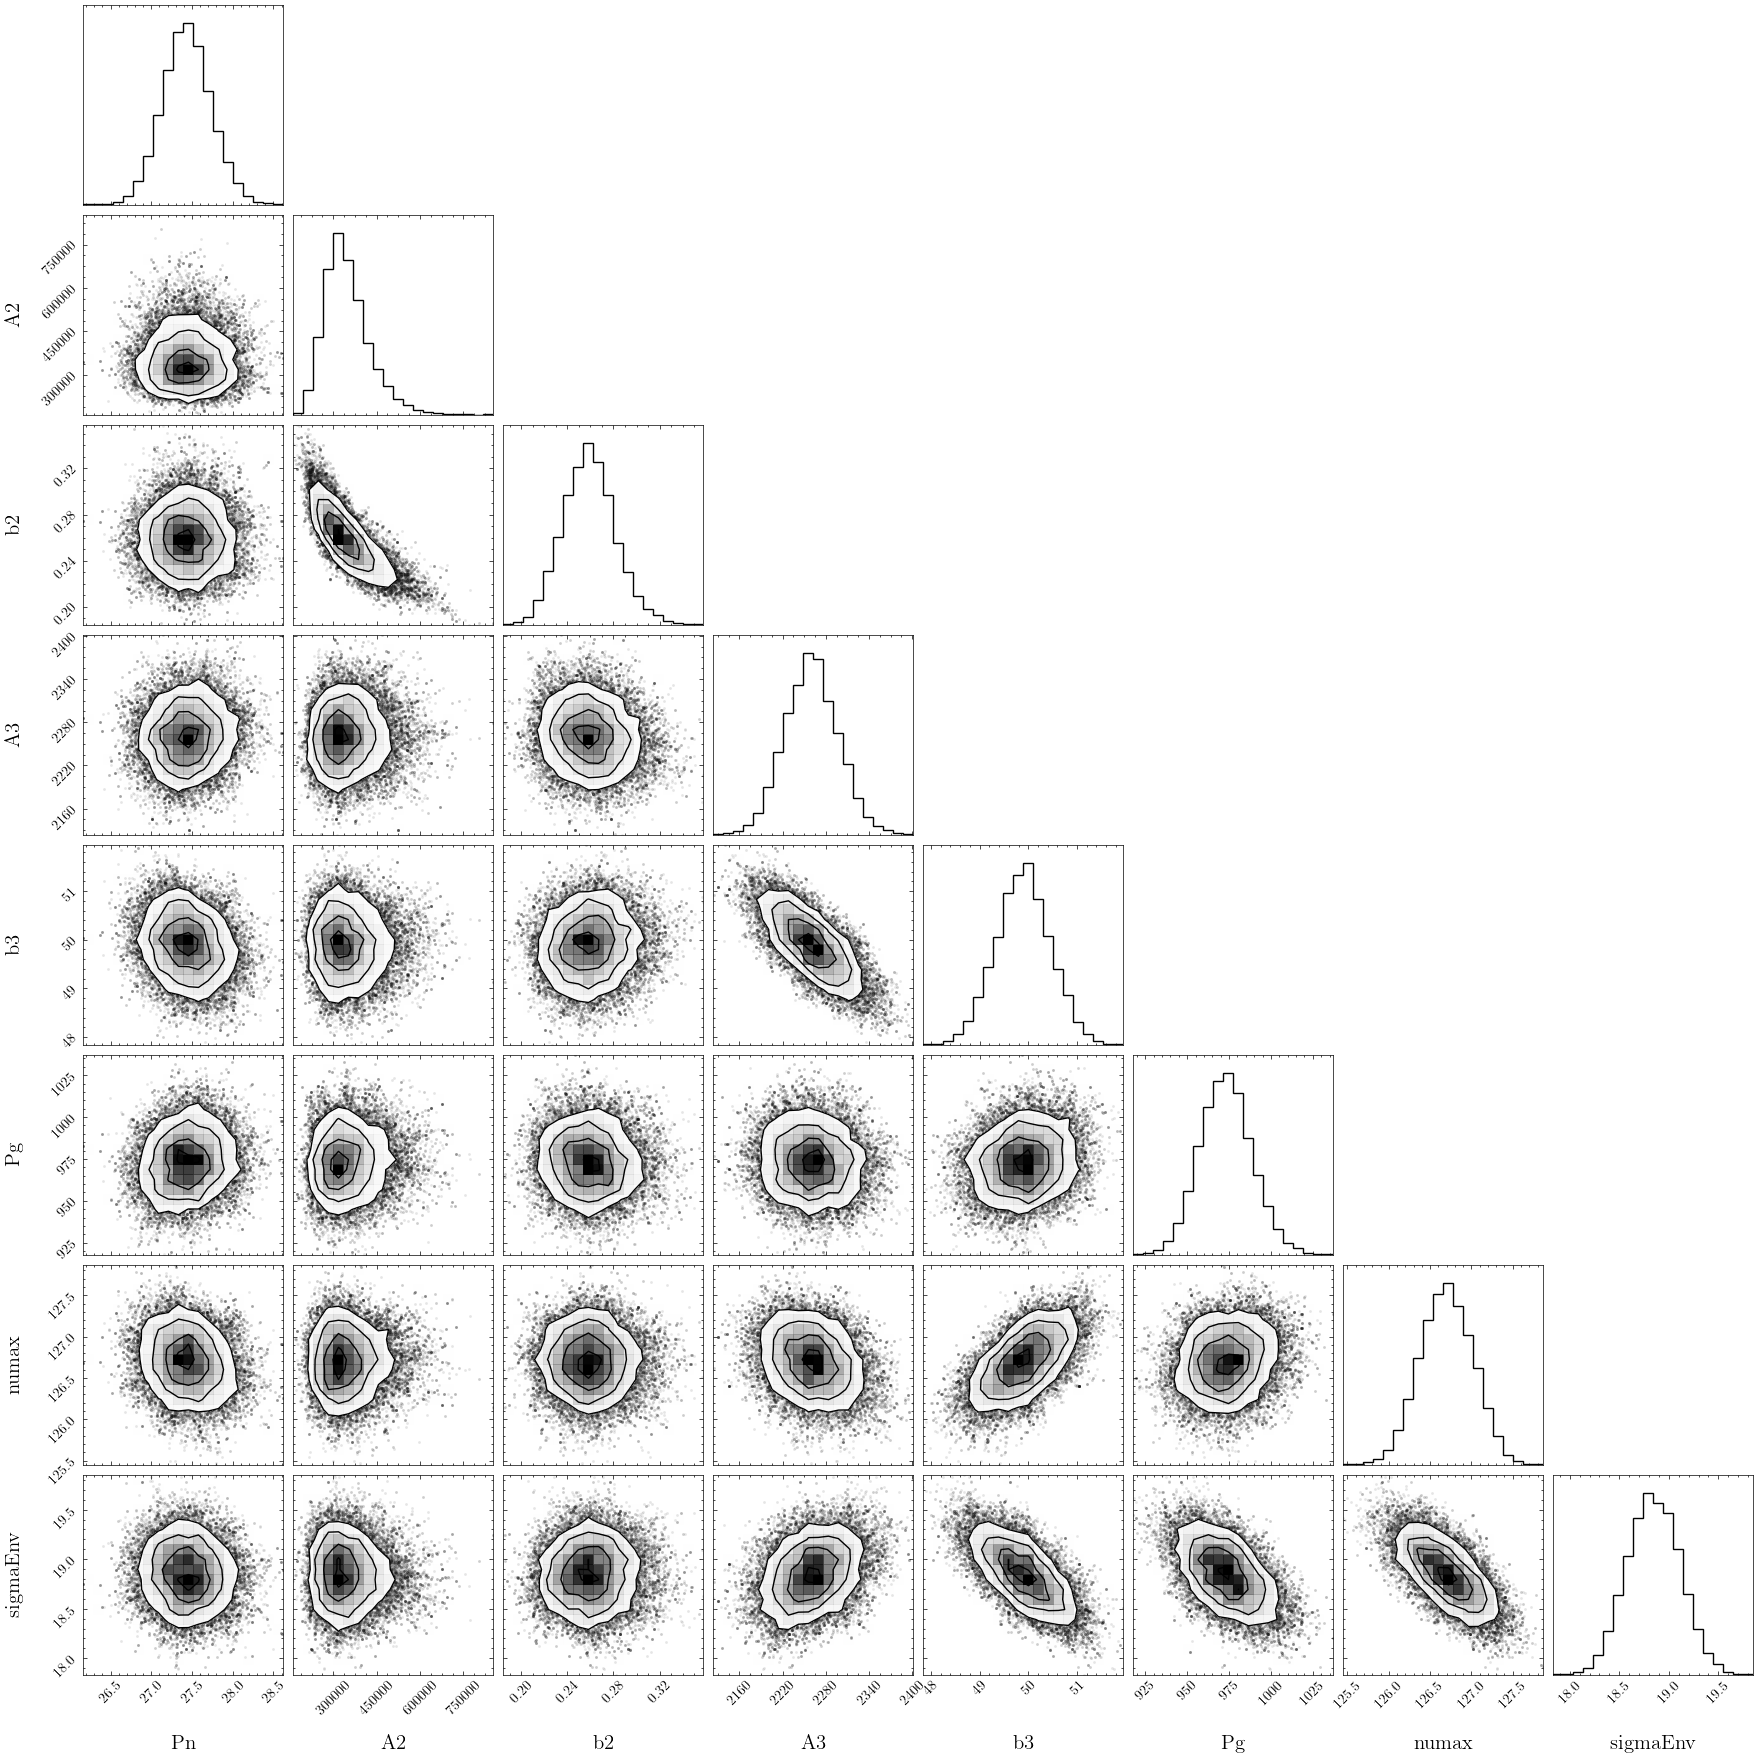

In [276]:
import corner
soln_labels = list(spec_mcmc.par_rels().keys())  # labels for sampled parameters

samples = sampler.chain[:, -500:, :].reshape((-1, ndim))  # obtain samples from emcee
fig = corner.corner(samples, labels = np.array(soln_labels)) # plotting the samples in a Corner plot!
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
plt.show()

> **Discarded Samples**  
> Notice that only the end portion of the chain was used as samples from the posterior distribution. This is because MCMC methods usually have a ***burn-in period*** during which the samples have not lost their initial state and are not yet "in equilibirum". Thus is it common practice for such early samples to be discarded.

The sampling look fairly uni-modal and well-behaved, which is good. To assess the convergence of the MCMC sampling, we will calculate the Gelman-Rubin statistic, or the $\hat{R}$ value, of each parameter using `arviz`. 

The $\hat{R}$ value is measured as the root of the ratio between the variance of the posterior distribution and the variance between chains. A value of $\hat{R} \approx 1$ indicates that the chains have converged to the same distribution, while $\hat{R}>1.01$ suggests that the chains have not fully converged -- more sampling would be required to explore the parameter space.

At the same time, we can report the properties of the posterior distribution by quoting the Highest Density Intervals (HDI) of the distribution using `arviz.hdi`.

In [277]:
import arviz as az

# Passed array should have shape (chains, draws, *shape)
idata = az.convert_to_inference_data({"x": np.transpose(sampler.get_chain(flat=False), (1, 0, 2))})

rhat = az.rhat(idata)
hdi = az.hdi(samples, hdi_prob=.68)

pd.DataFrame({
    'Parameter': [f"{p}" for p in soln_labels],
    '$\\hat{R}$': [f"{x:.4f}" for x in rhat.x],
    'Median': np.median(samples, 0),
    'Lower Bound': hdi[:,0],
    'Upper Bound': hdi[:,1],
})

,Parameter,$\hat{R}$,Median,Lower Bound,Upper Bound
0,Pn,1.0969,27.434082,27.122868,27.702815
1,A2,1.7139,337085.696905,256058.491052,394014.286183
2,b2,1.6977,0.258728,0.235383,0.279264
3,A3,1.1304,2260.199012,2223.901664,2297.077929
4,b3,1.1133,49.903325,49.341544,50.452351
5,Pg,1.0774,973.084882,956.793425,987.388597
6,numax,1.0854,126.701535,126.394430,127.033513
7,sigmaEnv,1.0854,18.847720,18.599037,19.127195


The $\hat{R}$ indicates that we likely haven't sampled enough draws. However, the cost of increasing the number of  draws can be prohibitively expensive! From the above example, it required 5 minutes for only 1,000 draws. While multiprocessing can certainly speed up the sampling process, there is a far more effective approach to this problem: ***binning the spectrum***.

### Binning the spectrum

Assuming that binning by performed by averaging over $p$ independent bins in the spectrum, this is equivalent to the addition of $p$ independent spectra, for which the total likelihood is the product of individual likelihoods:

$$
\begin{align}
    -\ln L_{\text{total}} = -\ln\bigg( \prod_{j=1}^p L_j \bigg) = \sum_{j=1}^p(-\ln L_j)
\end{align}
$$


Therefore, all that needs to be modified above is to scale the likelihood by the number of bins $p$ over which the spectrum is averaged.

First, we downsample the spectrum into only 1,000 bins and calculate the number of bins that we average over.

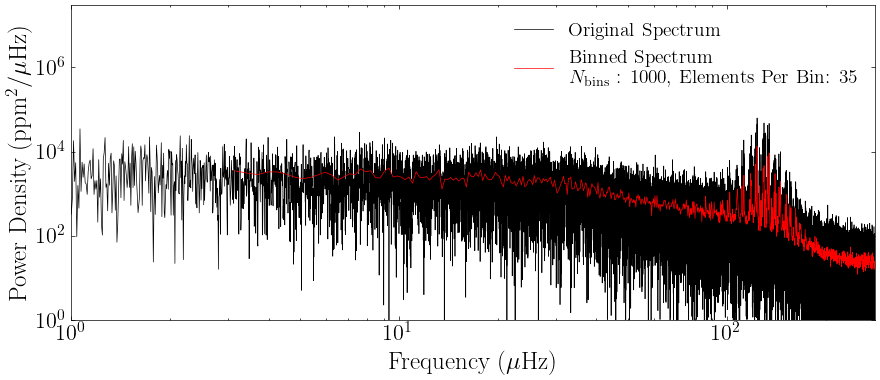

In [17]:
from scipy.stats import binned_statistic

freq_bins = np.linspace(3, 283, 1000)

binned_power, freq_binedges, _ = binned_statistic(freq,
                                      power,
                                      statistic=np.nanmean,
                                      bins = freq_bins)

binned_freq = 0.5*(freq_binedges[1:] + freq_binedges[:-1])
elements_per_bin = np.diff(binned_freq)[0]//np.diff(spec.freq)[0]


plt.figure(figsize=(9, 4))

plt.loglog(freq, power, c='k', lw=0.5, label='Original Spectrum')
plt.loglog(binned_freq, binned_power, c='red', lw=0.5,
           label='Binned Spectrum\n$N_{\mathrm{bins}}$ : %d, Elements Per Bin: %d' \
           %(len(freq_bins), elements_per_bin))

plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs)
plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
plt.xlim(1, 283)
plt.ylim(1, 3e7)
plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)

plt.legend(loc='best', prop={'size': fs-4})

plt.tight_layout(w_pad=1.5)
plt.show()

### The binned spectrum likelihood
Programmatically, all that needs to be done is to modify the log-likelihood function with a multiplicative constant.

In [20]:
class lnlike_mle_binned(object):
    def __init__(self, _freq, _power, _model, p0, elements_per_bin):
        self.freq = _freq
        self.power = _power
        self.model = _model # model power spectrum
        self.p0 = p0  # initial parameters to optimize
        self.elements_per_bin = elements_per_bin  # new

    def __call__(self, params, update_vars):
        
        for var, val in zip(update_vars, params):
            self.p0.update({var: val})
        
        # Construct model for given set of parameters
        mod = self.model(list(self.p0.values()), self.freq)

        like = np.sum(np.log(mod) + self.power / mod)
        if not np.isfinite(like):
            return 1.0e30
        return like*self.elements_per_bin

class lnlike_mcmc_binned(object):
    def __init__(self, _freq, _power, _model, elements_per_bin):
        self.freq = _freq
        self.power = _power
        self.model = _model
        self.elements_per_bin = elements_per_bin  # new
        
    def __call__(self, params):
        mod = self.model(params, self.freq)
        like = np.sum(np.log(mod) + (self.power / mod))
        return -1.0*like*self.elements_per_bin


We now defined a binned spectrum object, re-optimize, and re-run the MCMC. We should expect to see a dramatic speed ($\sim20$) up compared to the unbinned case. We can certainly afford to sample for more draws now.

In [21]:
spec_binned = Spectrum(_freq = binned_freq, _power = binned_power, _numax = 100)

## MLE ##
p0_dict = dict(zip(spec_binned.par_rels().keys(), spec_binned.initial_guess())) # Initial guess encoded in a dictionary
Lnlike_MLE = lnlike_mle_binned(spec_binned.freq, spec_binned.power, _model = bgModel, 
                               p0 = p0_dict, elements_per_bin = elements_per_bin)
result_p0 = optimize(p0_dict, vars=['A3', 'b3', 'Pn'])   # optimize A2, b2, keep others fixed
result_p0 = optimize(result_p0, vars=['A2', 'b2']) # optimize A3, b3, keep others fixed
result_p0 = optimize(result_p0, vars=['Pg', 'numax', 'sigmaEnv']) # optimize Pg, numax, sigmaEnv, keep others fixed
result_p0 = optimize(result_p0)

## MCMC ##

Lnlike_binned = lnlike_mcmc_binned(spec_binned.freq, spec_binned.power, _model = bgModel, elements_per_bin = elements_per_bin)
Lnprob_binned = lnprob(Lnlike_binned, spec_mcmc.prior)

ndim, nwalkers = len(np.array(list(result_p0.values()))), 100
draws = 20000

## Define starting position
pos = [np.array(list(result_p0.values())) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

init_time = timer.time()

sampler = emcee.EnsembleSampler(nwalkers, ndim, Lnprob_binned)
sampler.run_mcmc(pos, draws, rstate0=np.random.get_state(), progress=False)

print(f'Time Taken for {draws} iterations: {np.round(timer.time() - init_time)} seconds')

Time Taken for 20000 iterations: 298.0 seconds


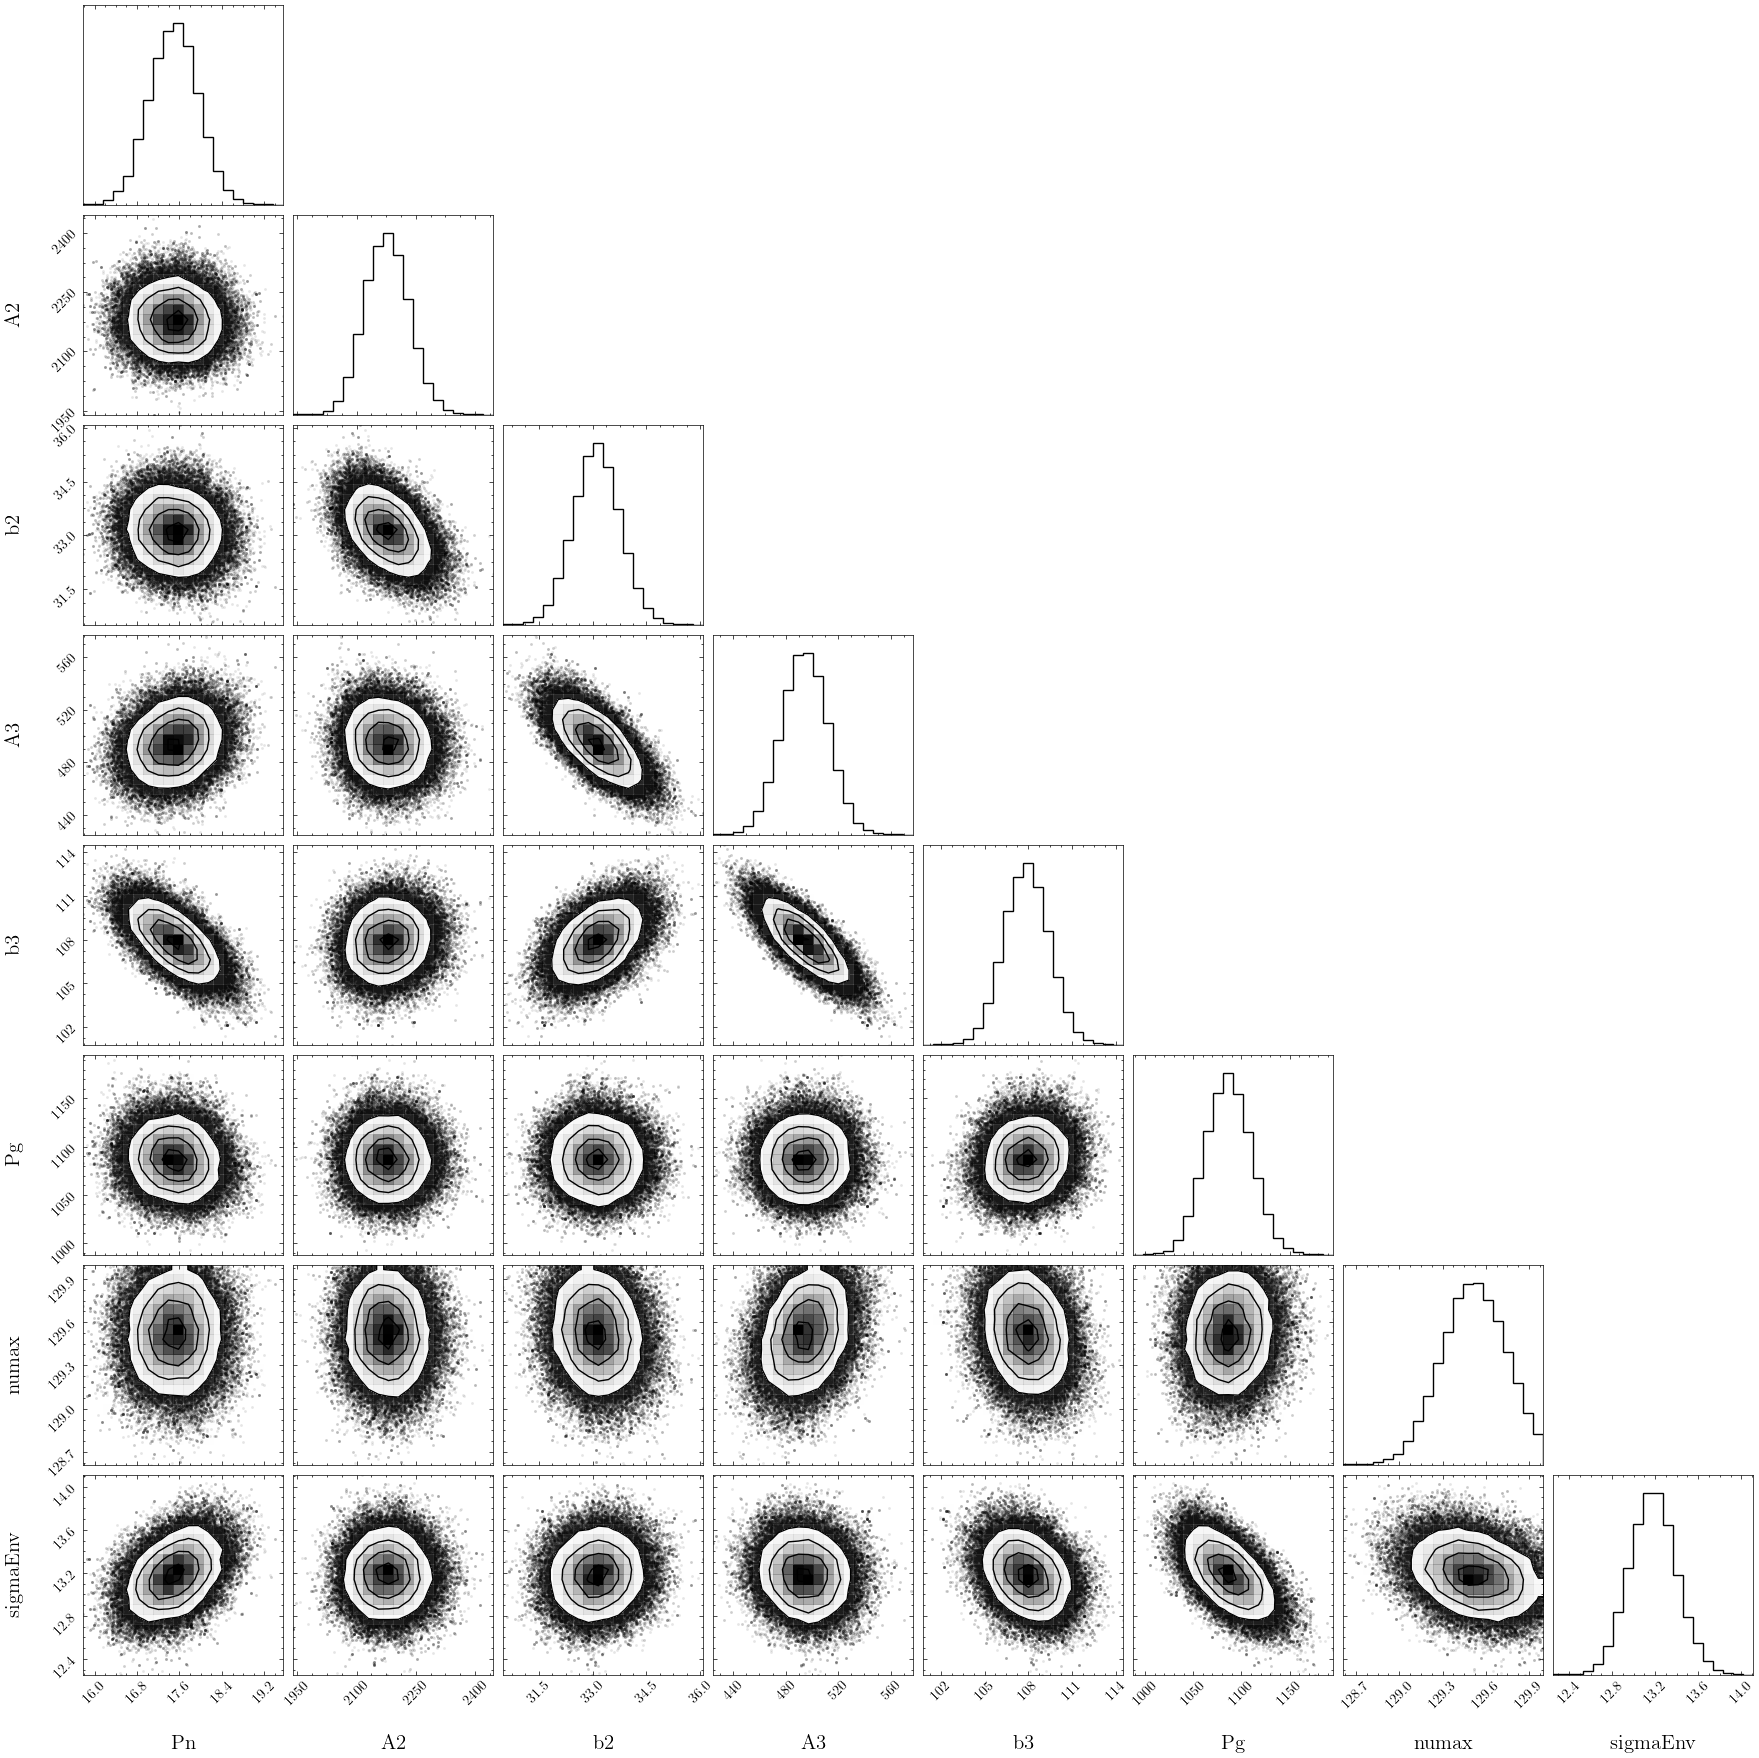

In [22]:
soln_labels = list(spec_mcmc.par_rels().keys())  # labels for sampled parameters

samples = sampler.chain[:, -2000:, :].reshape((-1, ndim))  # obtain samples from emcee
fig = corner.corner(samples, labels = np.array(soln_labels)) # plotting the samples in a Corner plot!
for ax in fig.axes:
    ax.xaxis.label.set_size(fs-3) 
    ax.yaxis.label.set_size(fs-3)
plt.show()

The sampled posterior distribution is identical to the unbinned case, and this is reflected in the derived posterior intervals as well. Being more thoroughly sampled, the $\hat{R}$ values now are more indicative of convergence.

In [25]:
# Passed array should have shape (chains, draws, *shape)
idata = az.convert_to_inference_data({"x": np.transpose(sampler.get_chain(flat=False), (1, 0, 2))})

rhat = az.rhat(idata)
hdi = az.hdi(samples, hdi_prob=.68)

pd.DataFrame({
    'Parameter': [f"{p}" for p in soln_labels],
    '$\\hat{R}$': [f"{x:.4f}" for x in rhat.x],
    'Median': np.median(samples, 0),
    'Lower Bound': hdi[:,0],
    'Upper Bound': hdi[:,1],
})

,Parameter,$\hat{R}$,Median,Lower Bound,Upper Bound
0,Pn,1.0050,17.506050,17.039948,17.938813
1,A2,1.0048,2177.591036,2123.578354,2232.909925
2,b2,1.0052,33.124135,32.523881,33.808159
3,A3,1.0051,494.717436,478.125483,512.623154
4,b3,1.0051,107.893362,106.339754,109.350789
5,Pg,1.0043,1086.849639,1062.594685,1109.466374
6,numax,1.0040,129.520181,129.306718,129.751426
7,sigmaEnv,1.0041,13.181892,12.964798,13.394667


## A Quick Sanity Check

Remember to always visualize your data! A quick sanity check that should consistently be done with your fitted model is to observe how well the draws from the posterior distribution fit the data. This is an example of a ***posterior predictive check***.

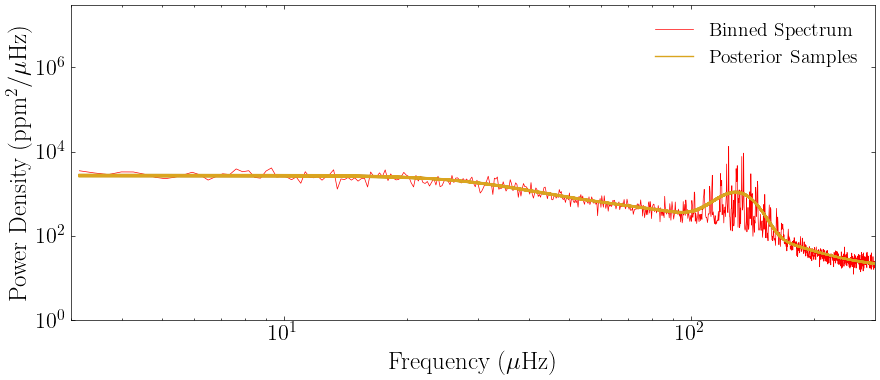

In [26]:
plt.figure(figsize=(9, 4))

plt.plot(spec_binned.freq, spec_binned.power, c='red', lw=0.5,
           label='Binned Spectrum')
plt.plot([], [], c='goldenrod', label='Posterior Samples')

for i, samps in enumerate(samples):
  if i % 200 == 0:
    plt.plot(spec_binned.freq, bgModel(samps, spec_binned.freq), c='goldenrod', alpha=0.2, lw=1)

plt.xlabel('Frequency ($\\mu$Hz)', fontsize=fs)
plt.ylabel('Power Density (ppm$^2/\\mu$Hz)', fontsize=fs)
plt.xlim(3, 283)
plt.ylim(1, 3e7)
plt.xscale('log')
plt.yscale('log')
plt.gca().tick_params(axis='both', which='major', labelsize=fs-2)


plt.legend(loc='best', prop={'size': fs-4})

plt.tight_layout(w_pad=1.5)
plt.show()